In [6]:
import numpy as np
from collections import Counter
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

RANDOM_STATE = 0

### Data load and explore
1. shape and size view
2. nan data check
3. class similarity

In [7]:
# loading
X_train = np.load('dataset/Assignment2Data/X_train.npy')
X_test = np.load('dataset/Assignment2Data/X_test.npy')
y_train = np.load('dataset/Assignment2Data/y_train.npy')
y_test = np.load('dataset/Assignment2Data/y_test.npy')

# data size and shape
print(f"Train size: {X_train.shape[0]}\nTest size: {X_test.shape[0]}\nImage shape: {X_test.shape[1:]}\n")

# Check nan values
def check_nan(data) -> bool:
    return np.isnan(data).any()

print(f"Nan value exists detect\nX_train: {check_nan(X_train)}\ny_train: {check_nan(y_train)}\nX_test: {check_nan(X_test)}\ny_test: {check_nan(y_test)}\n")

# num of class
cnt_class = Counter(y_train)
print(f"num of class: {cnt_class}")




Train size: 18928
Test size: 4732
Image shape: (28, 28)

Nan value exists detect
X_train: False
y_train: False
X_test: False
y_test: False

num of class: Counter({6: 4201, 10: 2196, 0: 1741, 9: 1682, 5: 1651, 4: 1562, 8: 1546, 7: 1519, 3: 978, 1: 936, 2: 916})


In [8]:
'''
Preprocess
label one-hot encode
'''
y_train_encoded = to_categorical(y_train, 11)
y_test_encoded = to_categorical(y_test, 11)

  1/592 ━━━━━━━━━━━━━━━━━━━━ 55s 94ms/step

/home/lxw/miniconda3/envs/ML_Lab/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/tmp/ipykernel_110953/114050381.py:35: RuntimeWarning: divide by zero encountered in divide
  similarity_matrics[i][j] = 1 / distance


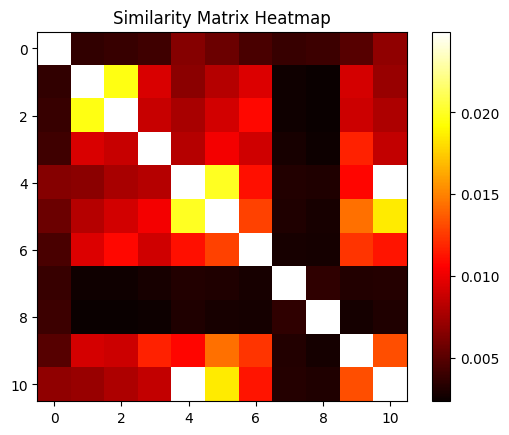

In [9]:
# Extract feature

input_shape = (28, 28, 1)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

all_features = model.predict(X_train)

# # average feature for each class
# feature_dict = {key:[] for key in cnt_class.keys()}
# class_avg_feature = {key:None for key in cnt_class.keys()}

# for idx, feature in enumerate(all_features):
#     feature_dict[y_train[idx]].append(feature)

# for key, features in feature_dict.items():
#     class_avg_feature[key] = np.mean(features, axis=0)

# # calculate similarity
# similarity_matrics = np.zeros((11, 11))

# sigma = 1.0 # similarity function param

# for i in range(11):
#     for j in range(11):
#         distance = np.linalg.norm(class_avg_feature[i] - class_avg_feature[j])
#         similarity_matrics[i][j] = 1 / distance

# # hot map visual
# plt.imshow(similarity_matrics, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.title('Similarity Matrix Heatmap')
# plt.show()  


### Model build
1. Linear SVC
2. Full connect NN
3. CNN

In [11]:
# Linear SVC

SVC_clf = LinearSVC(dual="auto", random_state=RANDOM_STATE, tol=1e-5)
SVC_clf.fit(all_features, y_train)

# Assessment
# accuracy, precision, recall, f1-score
y_pred = SVC_clf.predict(X_test, y_test_encoded)

acc_SVC = accuracy_score(y_test, y_pred)
pre_SVC = precision_score(y_test, y_pred, average='macro')
rec_SVC = recall_score(y_test, y_pred, average='macro')
f1_SVC = f1_score(y_test, y_pred, average='macro')

print(f"Acc: {acc_SVC}\nPre: {pre_SVC}\nRec: {rec_SVC}\nF1: {f1_SVC}\n")




In [ ]:
# Data Enhance (for both full connect NN and CNN)
train_datagen = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

train_datagen.flow(X_train, y_train, batch_size=4)

In [ ]:
# Training setting
train_size = 18928
test_size = 4732
batch_size = 4
epochs = 5
train_steps = train_size / batch_size
valid_steps = test_size / batch_size

In [ ]:
# Full connect NN

FCNN_model = Sequential()
FCNN_model.add(Flatten(input_shape=(28, 28, 1)))  
FCNN_model.add(Dense(128, activation='relu')) 
FCNN_model.add(Dense(1, activation='sigmoid'))

FCNN_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

FCNN_model.fit(
    train_datagen,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=(X_test, y_test_encoded),
    validation_steps=valid_steps
    )


In [ ]:
# CNN

input_shape = (28, 28, 1)

CNN = Sequential()

CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Flatten())

CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

CNN.fit(
    train_datagen,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=(X_test, y_test_encoded),
    validation_steps=valid_steps
    )